In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import OpenEXR
import Imath
import array


# %pylab inline
class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
        
def read_exr(filename):
    file = OpenEXR.InputFile(filename)
    dw = file.header()['dataWindow']
    size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

    # Read the three color channels as 32-bit floats
    FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)
    (R,G,B) = [array.array('f', file.channel(Chan, FLOAT)).tolist() for Chan in ("R", "G", "B")]

    # Normalize the data to the range [0, 1]
    img = np.zeros((size[1], size[0], 3), dtype=np.float32)
    # img[:,:,0] = np.array(R).reshape(size[1], size[0]) / max(R)
    # img[:,:,1] = np.array(G).reshape(size[1], size[0]) / max(G)
    # img[:,:,2] = np.array(B).reshape(size[1], size[0]) / max(B)
    img[:,:,0] = np.array(R).reshape(size[1], size[0]) #/ max(R)
    img[:,:,1] = np.array(G).reshape(size[1], size[0]) #/ max(G)
    img[:,:,2] = np.array(B).reshape(size[1], size[0]) #/ max(B)

    return img
    
def center_crop(img_array, new_width, new_height):
    height, width, _ = img_array.shape
    # print(height,width)
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = (width + new_width) // 2
    bottom = (height + new_height) // 2
    return img_array[top:bottom, left:right]


def simple_tone_mapping(img, gamma=2.2, exposure=1.0):
    return np.power(img * exposure, 1/gamma)



def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='#d8d8d8', lw=2,clip_on=False)

    ax.text((xmax+xmin)/2., yy+.09*yspan, text, ha='center', va='bottom',fontsize=20)
    



Bad key text.latex.preview in file /home/spock-the-wizard/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/spock-the-wizard/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.4/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/spock-the-wizard/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_

## Draw Error Plot

In [4]:

csvs = [
     "csv/fig6_botijo_alb.csv",
     "csv/fig6_botijo_sig.csv",
    # TODO: change to botijo!!
     "csv/fig6_kettle_alb.csv",
     "csv/fig6_kettle_sig.csv",
]


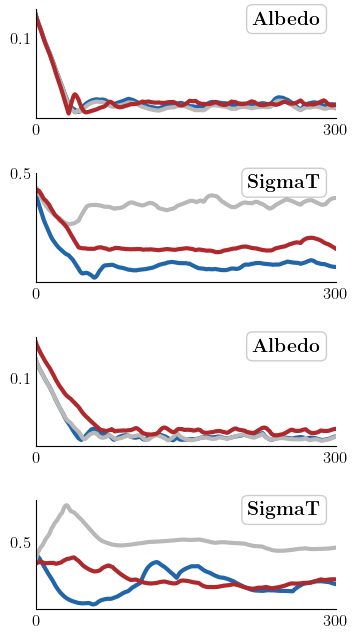

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import OpenEXR
import Imath
import array


# Set up matplotlib to use LaTeX for all text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "font.size": 18,
    "text.color": 'black',
    # 'axes.labelcolor': 'black',
})

n_cols = 1
n_rows = 4
size = 3

# Create figure and grid
fig = plt.figure(figsize=(size*n_cols,size*n_rows*0.5))
gs = fig.add_gridspec(n_rows, n_cols,
                      width_ratios=[1,]*n_cols,
                      # width_ratios=[1, 1, 1, 1, 1, 1],
                      height_ratios=[1,]*n_rows,
                     )

# Create subplots
for row in range(n_rows):
    for col in range(n_cols):        
        ax = fig.add_subplot(gs[row, col])
        
        # Step 1: Read the CSV file
        df  = pd.read_csv(csvs[row])
        
        # Step 2: Separate the time step column from the error columns
        time_steps = df.iloc[:, 0]  # First column as time steps
        data = df.iloc[:, 1:]  # Remaining columns as error data
        
        # Step 4: Plot each error column
        for idx,column in enumerate(data.columns):
            ax.plot(time_steps, data[column], label=column,color=colors[idx],linewidth=3)
            
        # Remove the box border (spines)
        for spine in ['top', 'right',]: # 'bottom', 'left']:
            ax.spines[spine].set_visible(False)
                
        plt.xticks(np.arange(0, 301, 300))  # X-axis ticks from 0 to 10 with a step of 
        ax.set_xlim(0,300)
        if row % 2 == 0:
            plt.yticks([0.1,])  # Y-axis ticks from -1 to 1 with a step of 0.5
            # ax.set_ylim(0,0.13)
        else:
            plt.yticks([0.5,])
            # ax.set_ylim(0,0.8)
                    
        # Remove tick marks but keep numeric labels
        ax.tick_params(axis='both', which='both', length=0, labelsize=12)
        title_text = r'$\textbf{' + ('Albedo' if row % 2 == 0 else 'SigmaT' ) + '}$'
        props = dict(boxstyle='round', facecolor='white', alpha=0.2)
        ax.text(0.95,0.99, title_text, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', horizontalalignment='right', bbox=props)
plt.tight_layout()

plt.subplots_adjust(hspace=0.5, wspace=0.0,left=0.0,top=1.0,right=1.0,bottom=0.0)

# plt.savefig(f'figures/fig6_plot.pdf',bbox_inches='tight') 
# plt.savefig(f'figures/fig6_plot.png',bbox_inches='tight') 
plt.show()

## Fig6: Comparison (Ours vs. Naive vs. Planar)

Increased resolution for BSSRDF model results (128 -> 512)

Data:
- botijo3 / sensor 1 / init: sigmaT 50.0, albedo 0.85 (mono)
- kettle1 / sensor 1 / init: same as above

Wandb Exp. Names (**project: shapeAdaptiveIR**):
- kettle: worthy-forest-64 (naive) / smart-star-43 (planar)

In [7]:
pths = [
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/botijo3/fig6_init_target/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/botijo3/fig6_planar/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/botijo3/fig6_naive/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/botijo3/fig6_ours/iter_1_1_out.exr",
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/botijo3/fig6_init_target/iter_1_1_gt.exr",
     "exp/fig6/csv/fig6_kettle.csv",
    
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle4/2024-08-01 17:06:25.613327/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle1/fig6_planar/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle1/fig6_naive/iter_1_1_out.exr",
    "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle1/fig6_ours/iter_1_1_out.exr",
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/kettle1/fig6_naive/iter_1_1_gt.exr",
     "/home/spock-the-wizard/slurm/sss-relighting/InverseTranslucent/exp/comp_ours/results_render/maneki4/fig4/iter_1_3_out.exr",
]


text_cols = ['(a) Initial',
            # '(b) Opt. \n(Planar)',
            # '(c) Opt. \n(Shape, Naive)',
            # '(d) Opt. \n(Shape, Ours)',
            '(b) Planar',
            # '(c) Shape Ada.' + r'$\textbf{(Na\"ive)}$',
            # '(d) Shape Ada.' + r'$\textbf{(Ours)}$',
            '(c) ShapeAda.' + '(Naive)',
            '(d) ShapeAda.(Ours)',
            # '(d) Shape (Ours)',
            '(e) Target',
             '(f) Param. RMSE'
            ]

colors=[
    '#2066a8', # Ours
    '#b8b8b8', # Naive
    '#ae282c' # Planar
]

space_cols = [
    # 1/6,
    1/12,
    1/12,
    1/12-0.01,
    1/12-0.01, 
    1/12-0.02, 
    1/12-0.02,
    0.01,
    -0.01,
    1/12,
]
text_rows = ['Botijo',
            'Kettle',
            ]
space_rows = [
    0.77,
    0.8,
]
scale = 0.9
list_imgs = []
for pth in pths:
    if pth.endswith('exr'):
        # Load exr
        img = read_exr(pth)
        img = center_crop(img,new_width=480,new_height=480)
                
        # Apply tone mapping
        img = simple_tone_mapping(img, gamma=2.2, exposure=1.5)
    elif pth.endswith('npy'):
        # Apply colormap
        img = np.load(pth)
    list_imgs.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(639, 357, 3)


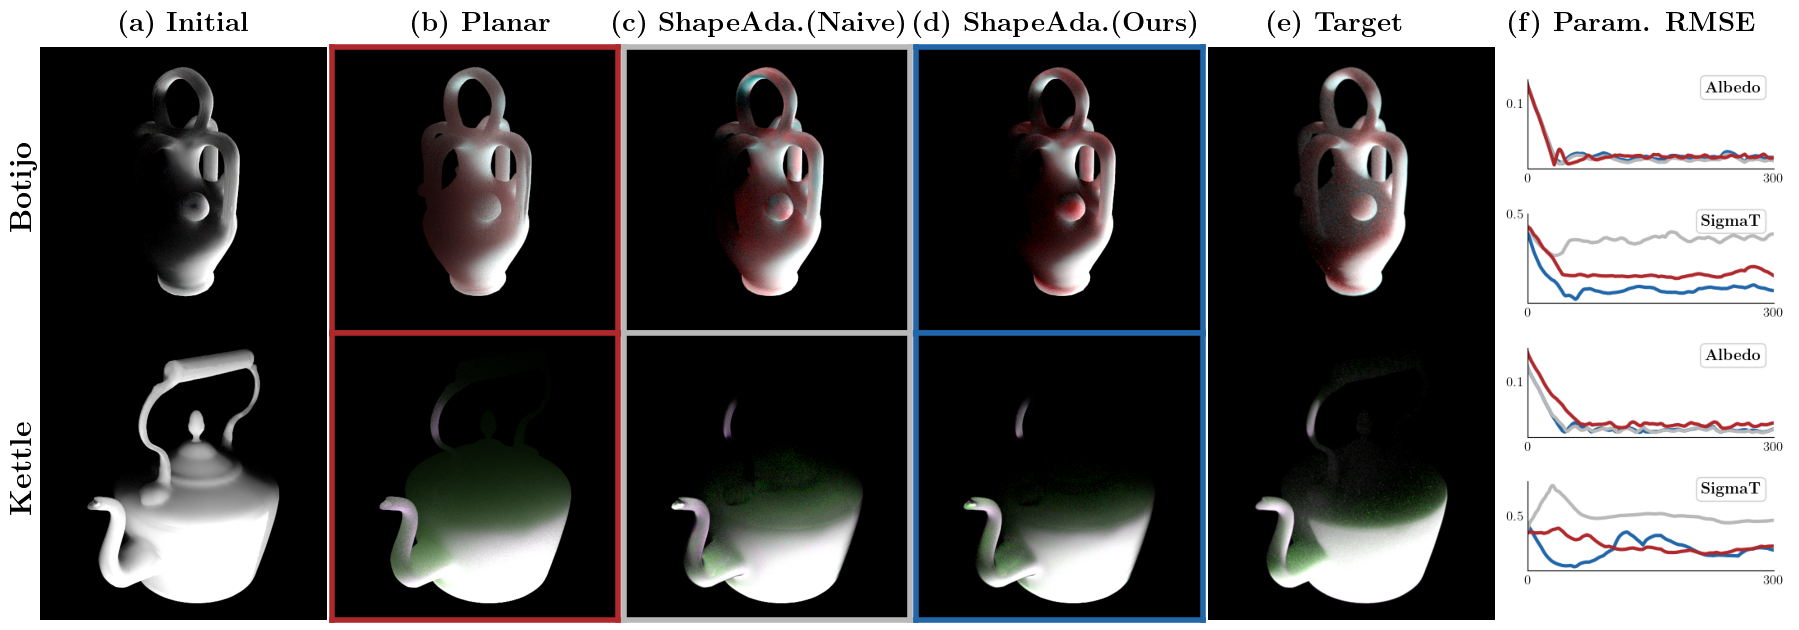

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import OpenEXR
import Imath
import array
import cv2



# Set up matplotlib to use LaTeX for all text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",
    "font.size": 18,
    "text.color": 'black',
    # 'axes.labelcolor': 'black',
})

n_cols = 6
n_rows = 2
size = 3

# Create figure and grid
fig = plt.figure(figsize=(size*n_cols-0.2,size*n_rows))
gs = fig.add_gridspec(n_rows, n_cols,
                      width_ratios=[1,]*n_cols,
                      # width_ratios=[1, 1, 1, 1, 1, 1],
                      height_ratios=[1, 1],
                     )

# Create subplots
for row in range(n_rows):
    for col in range(n_cols-1):
   
        ax = fig.add_subplot(gs[row, col])
        img = list_imgs[row*n_cols + col]
        
        im = ax.imshow(img)

        if col in [0,4,5]:
            ax.axis('off')
        else:
            for spine in ['top', 'right', 'bottom', 'left']:
                ax.spines[spine].set_visible(True)
                ax.spines[spine].set_color(colors[3 - col])
                ax.spines[spine].set_linewidth(4)
                
            ax.set_xticks([]) 
            ax.set_yticks([]) 
            
# Create the subplot that spans both rows in the last column
ax_plot = fig.add_subplot(gs[:, n_cols-1])
img = cv2.imread('figures/fig6_plot.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
im = ax_plot.imshow(img)    
ax_plot.axis('off') 


# Add column captions with LaTeX formatting
for col in range(n_cols):
    # fig.text(col/n_cols + space_cols[col], 1.03, r'$\textbf{' + text_cols[col] + '}$', # +r'$\textbf{' + text_cols[col] + '}$', 
             
    fig.text(col/n_cols + space_cols[col] ,1.04, r'$\textbf{' + text_cols[col] + '}$', ha='center', va='center',fontsize=20)

# Add row captions with LaTeX formatting
for row in range(n_rows):
    fig.text(-0.015, space_rows[row] - row*0.5, r'$\textbf{' + text_rows[row] + '}$', ha='left', va='center', rotation=90,fontsize=22)


# Adjust layout
plt.tight_layout()
# plt.subplots_adjust(top=0.85, left=0.05, right=0.95, bottom=0.05, wspace=0.1, hspace=0.2)

plt.subplots_adjust(left=0.0,top=1.0,hspace=0.0, wspace=0.00)

# plt.savefig(f'figures/fig6.pdf',bbox_inches='tight') 
# plt.savefig(f'figures/fig6.png',bbox_inches='tight') 
plt.show()

Naive 를 하면 parameter errror가 크나 색감 정도는 충분히 따라가는 것 확인. 
botijo 와 같이 shadow 가 많이 생기는 씬은 first bounce direct illumination만 고려하는 우리 모델한테 불리. naive 모델은 sigmaT가 낮아져서 훨씬 spread 가 큼. 결과적으로 이미지 로스 자체는 크게 차이가 나지 않음.

<span style="color:blue">Planar 모델 artifact 처리</span>.

<span style="color:red">Add 돋보기 annotation</span>.

### Plot Error (Individual)

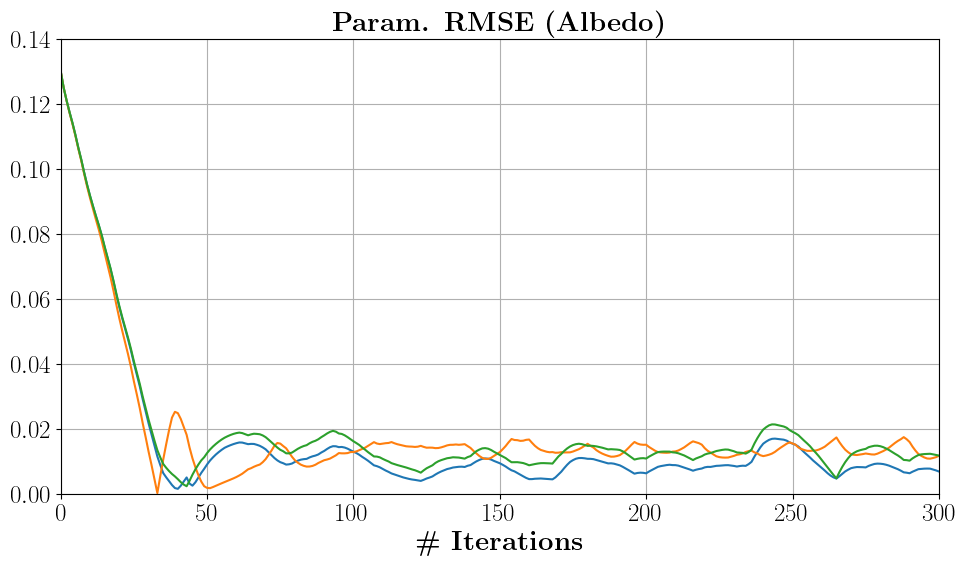

In [280]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('csv/fig6_kettle_alb.csv')

# Step 2: Separate the time step column from the error columns
time_steps = df.iloc[:, 0]  # First column as time steps
error_data = df.iloc[:, 1:]  # Remaining columns as error data

# Step 3: Create the plot
fig = plt.figure(figsize=(10, 6))  # Set the figure size

# Step 4: Plot each error column
for column in error_data.columns:
    plt.plot(time_steps, error_data[column], label=column)

# Step 5: Customize the plot
plt.title(r'\textbf{Param. RMSE (Albedo)}',fontsize=20)
plt.xlabel(r'\textbf{\# Iterations}',fontsize=20)
# plt.legend()
plt.grid(True)

ax = fig.gca()
# Set the axis range
ax.set_xlim(0, 300)
ax.set_ylim(0,0.14)

# Step 6: Display the plot
plt.tight_layout()
plt.show()

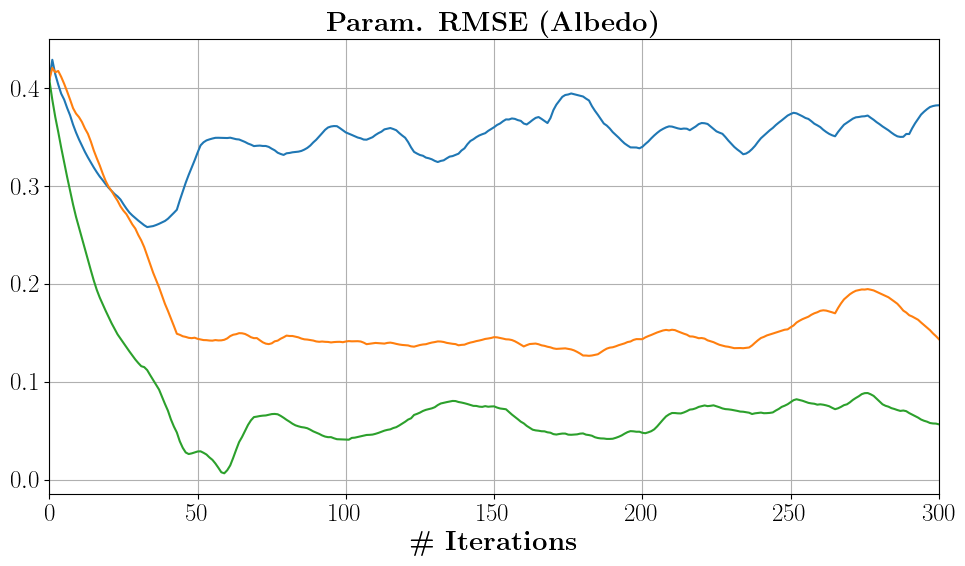

In [279]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('csv/fig6_kettle_sig.csv')

# Step 2: Separate the time step column from the error columns
time_steps = df.iloc[:, 0]  # First column as time steps
error_data = df.iloc[:, 1:]  # Remaining columns as error data

# Step 3: Create the plot
fig = plt.figure(figsize=(10, 6))  # Set the figure size

# Step 4: Plot each error column
for column in error_data.columns:
    plt.plot(time_steps, error_data[column], label=column)

# Step 5: Customize the plot
plt.title(r'\textbf{Param. RMSE (Albedo)}',fontsize=20)
plt.xlabel(r'\textbf{\# Iterations}',fontsize=20)
# plt.legend()
plt.grid(True)

ax = fig.gca()
# Set the axis range
ax.set_xlim(0, 300)
# ax.set_ylim(0,0.14)

# Step 6: Display the plot
plt.tight_layout()
plt.show()